Dataset preview:
                 Lastupdated           Status_Timestamp  Zone_Number  \
0  2024-12-05T02:44:37+03:00  2024-11-28T05:00:16+03:00       7084.0   
1  2024-12-05T02:44:37+03:00  2024-11-28T05:30:57+03:00       7084.0   
2  2024-12-05T02:44:37+03:00  2024-11-28T05:06:51+03:00       7084.0   
3  2024-12-05T02:44:37+03:00  2024-11-27T09:31:45+03:00       7084.0   
4  2024-12-05T02:44:37+03:00  2024-11-28T02:23:40+03:00       7084.0   

  Status_Description  KerbsideID                                Location  
0            Present        8729   -37.80220387416213, 144.9609413122746  
1            Present        8735  -37.80223335664963, 144.96120480793184  
2         Unoccupied        8741   -37.8022649761665, 144.96149743252016  
3         Unoccupied        8747  -37.80229720947396, 144.96179210870582  
4         Unoccupied        8749   -37.80230361629087, 144.9618505999636  

Model: RandomForestClassifier
Accuracy: 0.7083
Classification Report:
              precision    re

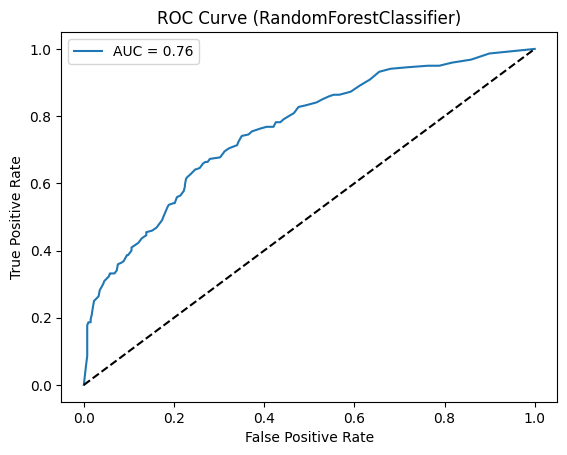

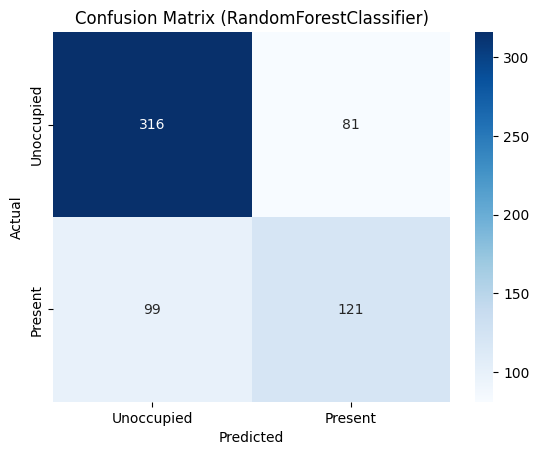


Model: LogisticRegression
Accuracy: 0.7131
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.81       397
           1       0.70      0.34      0.46       220

    accuracy                           0.71       617
   macro avg       0.71      0.63      0.63       617
weighted avg       0.71      0.71      0.68       617



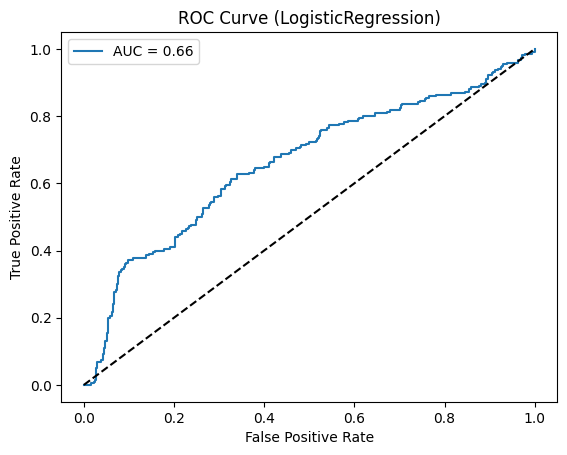

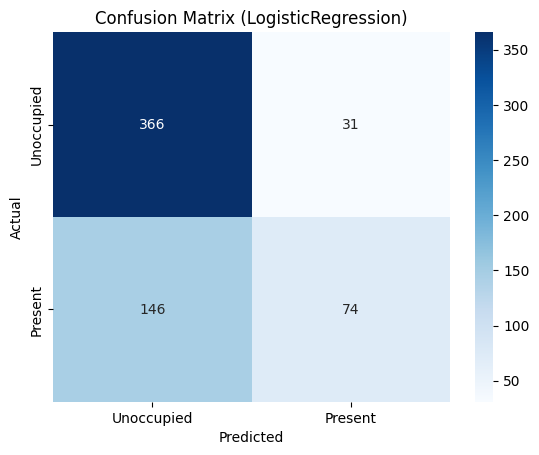


Model: SVC
Accuracy: 0.7358
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.82       397
           1       0.74      0.40      0.52       220

    accuracy                           0.74       617
   macro avg       0.74      0.66      0.67       617
weighted avg       0.74      0.74      0.71       617



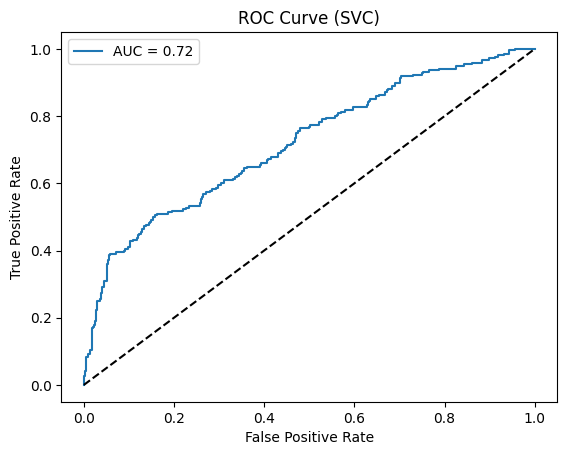

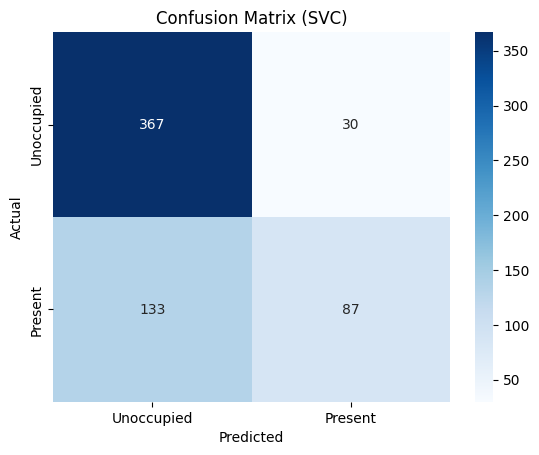


Model: DecisionTreeClassifier
Accuracy: 0.7002
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       397
           1       0.58      0.58      0.58       220

    accuracy                           0.70       617
   macro avg       0.67      0.67      0.67       617
weighted avg       0.70      0.70      0.70       617



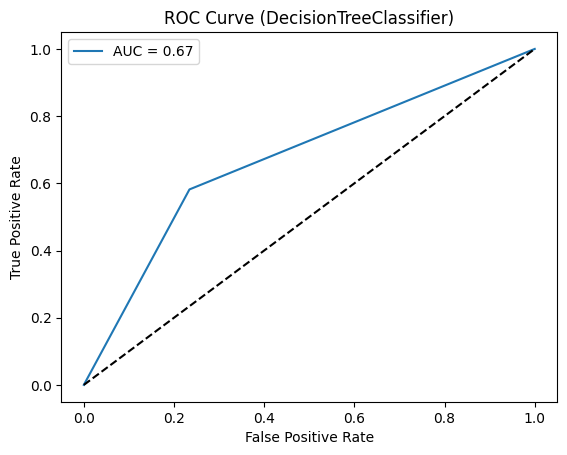

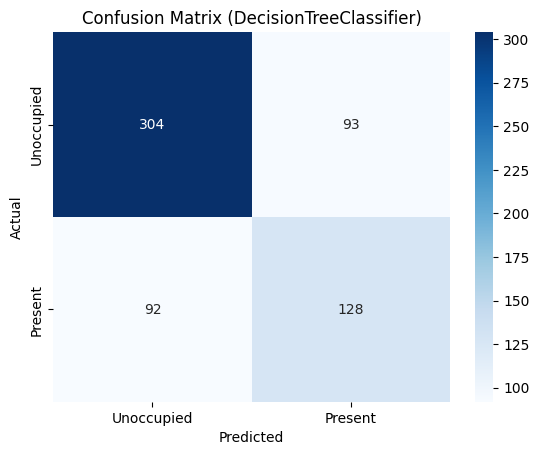

In [1]:
# Import necessary libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For enhanced data visualizations
from sklearn.model_selection import train_test_split  # To split dataset into training and testing sets
from sklearn.preprocessing import LabelEncoder, StandardScaler  # For label encoding and feature scaling
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score  # For evaluating models
from sklearn.ensemble import RandomForestClassifier  # Random Forest model
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree model

# Load the dataset
file_path = r"C:\Users\billj\OneDrive\מסמכים\smart-parking-system\Dataset\parking_sensor_data.csv"  # Replace Path with your actual dataset path
data = pd.read_csv(file_path)  # Load data into a DataFrame

# Quick look at the dataset
print("Dataset preview:")
print(data.head())  # Display the first few rows of the dataset

# Convert datetime columns
data['Lastupdated'] = pd.to_datetime(data['Lastupdated'])  # Convert 'Lastupdated' to datetime format
data['Status_Timestamp'] = pd.to_datetime(data['Status_Timestamp'])  # Convert 'Status_Timestamp' to datetime format

# Handle missing values
data = data.dropna()  # Remove rows with missing values

# Feature engineering: Add time-based features
data['hour'] = data['Status_Timestamp'].dt.hour  # Extract the hour from the timestamp
data['day_of_week'] = data['Status_Timestamp'].dt.dayofweek  # Extract the day of the week (0=Monday, 6=Sunday)
data['month'] = data['Status_Timestamp'].dt.month  # Extract the month

# Convert 'Status_Description' to numerical labels
label_encoder = LabelEncoder()  # Initialize the LabelEncoder
data['Status_Description'] = label_encoder.fit_transform(data['Status_Description'])  # Encode the target column

# Extract latitude and longitude from the 'Location' column
data[['latitude', 'longitude']] = data['Location'].str.split(',', expand=True).astype(float)  # Split 'Location' into latitude and longitude and convert to float

# Define features and target
X = data[['hour', 'day_of_week', 'month', 'latitude', 'longitude']]  # Select feature columns
y = data['Status_Description']  # Define the target variable (encoded parking status)

# Scale the features
scaler = StandardScaler()  # Initialize the StandardScaler
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  # Scale the features and convert back to DataFrame

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split into training (80%) and testing (20%)

# Evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)  # Fit the model to the training data
    y_pred = model.predict(X_test)  # Make predictions on the test data
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  # Get prediction probabilities (if available)

    # Print performance metrics
    print(f"\nModel: {model.__class__.__name__}")  # Print the model name
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")  # Calculate and print accuracy
    print("Classification Report:")  
    print(classification_report(y_test, y_pred))  # Print precision, recall, F1-score, etc.

    # Plot ROC curve if probabilities are available
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Compute the ROC curve
        plt.figure()  
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")  # Plot the ROC curve
        plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal reference line
        plt.title(f"ROC Curve ({model.__class__.__name__})")  # Add a title
        plt.xlabel("False Positive Rate")  # Label x-axis
        plt.ylabel("True Positive Rate")  # Label y-axis
        plt.legend()  # Add legend
        plt.show()  # Display the plot

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)  # Compute the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Unoccupied', 'Present'], 
                yticklabels=['Unoccupied', 'Present'])  # Create a heatmap
    plt.title(f"Confusion Matrix ({model.__class__.__name__})")  # Add a title
    plt.xlabel("Predicted")  # Label x-axis
    plt.ylabel("Actual")  # Label y-axis
    plt.show()  # Display the heatmap

# List of models to test
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),  # Random Forest model
    LogisticRegression(random_state=42),  # Logistic Regression model
    SVC(probability=True, random_state=42),  # Support Vector Classifier with probabilities
    DecisionTreeClassifier(random_state=42)  # Decision Tree model
]

# Evaluate each model
for model in models:  # Loop through each model
    evaluate_model(model, X_train, X_test, y_train, y_test)  # Evaluate and print results
